# 시작

In [2]:
import os, tarfile
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 

In [3]:
def load_image(file_name):
    path = os.getenv('HOME') + '/aiffel/human_segmentation/images'
    image_path = os.path.join(path, file_name)
    image = cv2.imread(image_path)
    print('사진을 불러왔습니다: {}'.format(image.shape))
    print(image_path)
    return image

# 모델 생성

In [4]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [5]:
def load_model():
    model_path = os.getenv('HOME') + '/aiffel/human_segmentation/models/deeplab_model.tar.gz'
    model = DeepLabModel(model_path)
    print('모델을 불러왔습니다')
    return model

# 이미지 처리

In [19]:
def make_focus(image, seg_map, target='person'):
    image_bg = image.copy()
    
    LABEL_NAMES = [
        'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
        'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
        'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
    ]
    target_index = LABEL_NAMES.index(target)
    target_seg = np.where(seg_map==target_index, target_index, 0)
    mask = (target_seg * 255 / target_seg.max()).astype(np.uint8)
    
    resized_mask = cv2.resize(mask, image.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
    _, resized_mask = cv2.threshold(resized_mask, 128, 255, cv2.THRESH_BINARY)
    color_mask = cv2.cvtColor(resized_mask, cv2.COLOR_GRAY2BGR)
    bg_mask = cv2.bitwise_not(color_mask)

    blured_image_bg = cv2.blur(image_bg, (13, 13))
    masked_image_bg = cv2.bitwise_and(blured_image_bg, bg_mask)

    result_image = np.where(color_mask == 255, image, masked_image_bg)
    return result_image

# 이미지 보여주기

In [12]:
def show_image(image):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# 메인

사진을 불러왔습니다: (450, 800, 3)
/home/ssac5/aiffel/human_segmentation/images/my_image.png
모델을 불러왔습니다
(450, 800)
(800, 450)


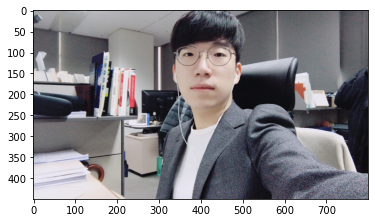

In [17]:
image = load_image('my_image.png')
model = load_model()

show_image(image)
print(image.shape[:2])
print(image.shape[:2][::-1])

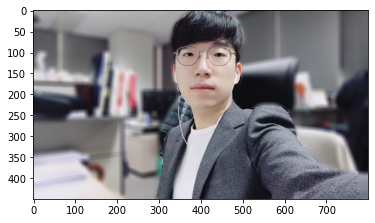

In [20]:
resized_image, seg_map = model.run(image)
result_image = make_focus(image, seg_map)
show_image(result_image)